# Mini Projet

## Ex 1: Exploration des données, recherche de leur loi

In [1]:
import numpy as np
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# get data
df = pd.read_csv("http://innovwiki.ethz.ch/v1/images/NuclearPowerAccidents2016.csv")

# rename col
df["Cost"] = df["Cost (millions 2013US$)"]

# set index as a datetime index
df.Date = pd.to_datetime(df.Date)
df.set_index("Date", inplace=True)

# remove unused cols & NaN values
df = df[~df.isna().Cost][["Location", "Cost"]]

# select the good time range
df = df.loc[df.index < pd.to_datetime("1979-03-28")]
q1 = np.array(df.Cost)
print(len(q1))

55


Montrons 
$$
    F^{-1}(p; \mu, \sigma^2) = \mu + \sqrt{\sigma^2} F^{-1}(p; 0,1)
$$

Prenons $y$ et $x$ tels que $F(x,\mu,\sigma^2) = y$; donc $F^{-1}(y,\mu,\sigma^2) = x$;

$F(x, \mu, \sigma^2) = \int_{0}^{x} \frac{1}{\sigma\sqrt{2\pi}} e^{ \frac{1}{2} (\frac{t-\mu}{\sigma})^2 } \mathrm{d}t$

On fait le changement de variable linéaire $z = \frac{t-\mu}{\sigma}$. Donc $\mathrm{d}z = \frac{\mathrm{d}t}{\sigma}$

Donc $F(x, \mu, \sigma^2) = \int_{0}^{\frac{x-\mu}{\sigma}} \frac{1}{\sqrt{2\pi}} e^{ \frac{1}{2} z^2 } \mathrm{d}z$

Donc $y = F(x, \mu, \sigma^2) = F(\frac{x-\mu}{\sigma}; 0, 1)$

Donc $F^{-1}(y; 0, 1) = \frac{x-\mu}{\sigma}$

Donc $\mu + \sqrt{\sigma^2} F^{-1}(y; 0, 1) = x$

Vu que $x = F^{-1}(y,\mu,\sigma^2)$, on a donc:
$$
\mu + \sqrt{\sigma^2} F^{-1}(y; 0, 1) = F^{-1}(y,\mu,\sigma^2)
$$

### Tracer le QQ-plot de données pour la loi normale

La fonction `probplot` fournie par `scipy.stats` a un parametre `dist` pour choisir la loi.
Par défault il plot la loi normale.

In [6]:
# QQ-Plot normal
stats.probplot(q1, plot=plt.subplot())
plt.show()

Les donnés n'on pas vraiment l'air de fit avec une droite...

Montrons $$ F^{-1}(y; \lambda) = \frac{1}{\lambda} F^{-1}(y;1)$$

Soit $x$ et $y \in (0;1)$ tels que $F(x) = 1 - e^{-\lambda x} = y$. Donc $x = -\frac{ln(1-y)}{\lambda}$.

Donc $F^{-1}(y; \lambda) = \frac{1}{\lambda} * (-ln(1-y)) = \frac{1}{\lambda} * F^{-1}(y; 1)$.

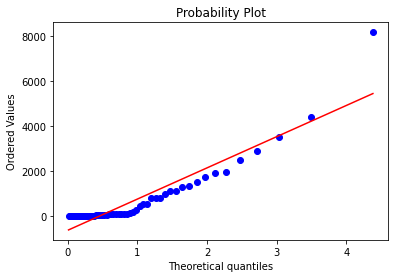

In [4]:
# QQ-Plot normal
stats.probplot(q1, dist="expon", plot=plt.subplot())
plt.show()

Cette loi ci semble bien plus plausible: Mis a part le dernier point qui représente les valeurs extremes, les donnés sont alignés sur une droite.
La loi exponentielle est donc celle retenue pour modéliser les donnés.

Cela parait cohérent avec la problématique métier : Les accidents sont assez rares et le prix de ce genre d'incidents suit souvant une loi exponentielle.

## Ex 2: Estimation ponctuelle des paramètres d’une loi exponentielle

Soit $x = (x_1, x_2, ..., x_n)$ et $p_λ$ la densité de X, exponentielle de paramètre $λ$

$p_λ(x) = \prod_{i=1}^{n} λ e^{λ x_i} \mathbb{1}(x_i) = λ^n e^{λ\sum_{i=1}^n xi} \prod_{i=1}^n \mathbb{1}(x_i)$

Donc $L(λ) = \mathrm{log} p_λ(x) = n \mathrm{log} λ - λ \sum_{i=1}^n x_i + \sum \mathrm{log}(\mathbb{1}(x_i)) = n \mathrm{log} λ - λ \sum_{i=1}^n x_i + c$

Donc $\frac{\partial L}{\partial λ} = n/λ - \sum_{i=1}^n x_i$

$\frac{\partial L}{\partial λ} = 0$ équivaut à $n/λ = \sum_{i=1}^n x_i$

Donc $λ = n/(\sum_{i=1}^n x_i)$

$\frac{\partial^2 L}{\partial λ^2} = -n/λ^2$, donc L est concave, donc le maximum de vraisemblance $\hat{λ}_n = n/(\sum_{i=1}^n x_i)$

In [12]:
lambda_hat = 1/np.mean(q1)
x = np.linspace(0, 8000)
plt.plot(x, lambda_hat*np.exp(-x*lambda_hat))
plt.hist(q1, density=True)
plt.show()

La courbe a l'air de coller aux donnés, de plus la valeur de  $\hat{λ}_n$ parait assez logique.

Montrons que $T_1(X)$ est efficace pour la grandeur d'intérêt $g_1(λ)$.

$ \mathbb{E}(T_1(X)) = \mathbb{E}( 1/n \sum X_i ) = 1/n \sum \mathbb{E}(X_i) ) = \frac{1}{n} * n/λ = 1/λ $
Donc $ \mathbb{E}(T_1(X)) = g_1(λ) $, donc $T_1(X)$ est non-biaisé.

$ \mathbb{V}(T_1(X)) = \mathbb{V}( 1/n \sum X_i ) = 1/n^2 \sum \mathbb{V}(X_i) ) = \frac{1}{n^2} * n/λ^2 = \frac{1}{n λ^2} $ (Les $X_i$ sont indépendantes, donc les covariances sont nulles.)

Pour $n = 1$, $I(λ) = -\mathbb{E}( \frac{\partial^2 \mathrm{log}p_λ(x)}{\partial λ^2} )$

$\mathrm{log} p_λ (x) = \mathrm{log} (λ e^{-λx} \mathbb{1}_\mathbb{R^+}(x)) = logλ - λx + c$

$\frac{\partial \mathrm{log}p_λ}{\partial λ} = \frac{1}{λ} - x$

$\frac{\partial^2 \mathrm{log}p_λ}{\partial λ^2} = -\frac{1}{λ^2}$

Donc $I(λ) = 1/λ^2$

Donc pour $n \in \mathbb{N}^*$, $I(λ) = n/λ^2$

Ainsi $ g_1\prime(λ)^2 / I(λ) = (1/λ^2)^2 / (n/λ^2) = 1/nλ^2$

Ainsi $\mathbb{V}(T_1(X)) = g_1'(λ) / I(λ)$. $T_1(X)$ est donc efficace pour $g_1$.

In [15]:
g1 = np.mean(q1)
print(f"{g1=:.3f}")

g1=726.336


$R_1(g_1(λ), T_1(X)) = b(g_1(λ), T_1(X))^2 + \mathbb{V}(T_1(X)) = 0 + \frac{1}{n λ^2}$

$R_2(g_1(λ), \tilde{T}_{1,η}(X)) = b(g_1(λ), \tilde{T}_{1,η}(X))^2 + \mathbb{V}(\tilde{T}_{1,η}(X)) $

$R_2(g_1(λ), \tilde{T}_{1,η}(X)) = (\mathbb{E}(\tilde{T}_{1,η}(X)) - g_1(λ))^2 + \mathbb{V}(\tilde{T}_{1,η}(X)) $

$R_2(g_1(λ), \tilde{T}_{1,η}(X)) = (\mathbb{E}(η T_1(X)) - g_1(λ))^2 + \mathbb{V}(η T_1(X)) $

$R_2(g_1(λ), \tilde{T}_{1,η}(X)) = (η \mathbb{E}(T_1(X)) - g_1(λ))^2 + η^2\mathbb{V}(T_1(X)) $

$R_2(g_1(λ), \tilde{T}_{1,η}(X)) = (η/λ - 1/λ)^2 + (1/n) (η/λ)^2) = (1/λ)^2 ((η -1)^2 + η^2/n$

Donc $R_2(g_1(λ)) < R_1(g_1(λ))$ équivaut à $((η -1)^2 + η^2/n < 1/n$ et donc $(η-1)^2 + η^2/n - 1/n < 0$

On développe et on obtient: $η^2(1+1/n) - 2η + (1 - 1/n) < 0$

Le discriminant est $(-2)^2 - 4(1+1/n)(1-1/n) = 4(1-(1-1/n^2)) = 4/n^2 > 0$, et le coefficient devant le terme en $η^2$ est positif ($1+1/n > 0$ car $n>0$), donc le trinôme est négatif entre ses deux racines, qui sont:

$$ \frac{-b \pm \sqrt{Δ}}{2a} = \frac{+2 \pm \sqrt{4/n^2}}{2(1+1/n)} = \frac{1 \pm 1/n}{1 + 1/n} $$

c'est à dire $\frac{1 - 1/n}{1 + 1/n} = \frac{n - 1}{n + 1}$ (qui est inférieur à 1) et $1$.

On a trouvé précedemment un estimateur non-biaisé pour $η = 1$. Pour certaines valeurs de η, on obtient un estimateur de risque moindre mais biaisé, donc pas optimal. Mais pas de problème vu que dans ces cas là $η$ < 1.

 La médiane d'une loi exponentielle est $ln(2)/λ$. On cherche donc $η$ tel que $ b(\mathrm{ln}(2)/λ, \tilde{T}_{1,η}(X)) = \mathbb{E}(\tilde{T}_{1,η}(X)) - \mathrm{ln}(2)/λ = 0$
 
 Comme $ \mathbb{E}(\tilde{T}_{1,η}(X)) = η/λ$, il faut prendre $η = \mathrm{ln}(2)$.

In [33]:
estimateur_mediane = np.log(2) * np.mean(q1)
mediane_empirique = np.median(q1)
print(f"{estimateur_mediane=:.3f}\n{mediane_empirique=:.3f}")

# for i in range(1, 20):
#     print(i, np.log(2) * np.mean(sorted(list(q1))[:-1*i]))

estimateur_mediane=503.458
mediane_empirique=89.900


Pas très cohérent, on peut se demander s'il n'y a pas une faute de calcul.
Si les calculs sont bons, l'estimateur n'est pas très bon.

En suposant que l'érreur est due a des valeurs extremes, il faudrait en retirer ~10 ce qui n'est pas très cohérents. Cela renforce ma crédence dans une errreur de calculs.

$R_2(g_1(λ)) < R_1(g_1(λ))$ équivaut $ \frac{n - 1}{n + 1} < η < 1$

Pour $η = \mathrm{ln}(2)$, la contrainte $η < 1$ est vérifiée donc on cherche $n$ telle que $\frac{n - 1}{n + 1} < \mathrm{ln}(2)$. Cela équivaut à $n - n\mathrm{ln}(2) < 1 + \mathrm{ln}(2)$, puis à $n < (\mathrm{ln}(2) + 1)/(1 - \mathrm{ln}(2)) \approx 5.5$

Il faut donc n <= 5 pour avoir un estimateur de la médiane à moindre risque et optimal.

## Ex 3: Test sur le paramètre d’une loi

$H_0$: "le coût moyen d’un accident est inférieur à un milliard de dollars"

$H_1$: "le coût moyen d’un accident est supérieur à un milliard de dollars"

Le modèle étant exponentielle pour un certain paramètre $λ$, le coût moyen est $1/λ$. On pose donc $1/λ_0 = 10^9$ (en dollars)

L'hypothèse nulle est unilatérale. On va donc utiliser le rapport de vraisemblance. Soit donc $λ\prime > λ$ et $x = (x_1, ..., x_n)$.

Soit $s = x_1 + ... + x_n$, et $α$ et $c$ tels que $P_{λ_0}(s > c) = α$.

$p(x, λ\prime) / p(x, λ) = \prod_{i=1}^n \lambda e^{-\lambda x_i} /  \prod_{i=1}^n \lambda e^{-\lambda\prime x_i} = ({\lambda} / {\lambda'})^n e^{(\lambda' - \lambda)s}$.

Le rapport de vraisemblance est donc une fonction croissante de $s$, qui est une statistique de $x$.

D'après le cours, il existe donc un test $δ$ U.U.P. de niveau α défini par:

$δ(x) = 1 $ si $ s > c$

$δ(x) = 0 $ si $ s \leq c$

$s$ suit une loi $Γ(n, 1/λ)$ car c'est la somme de $n$ lois exponentielles de paramètre $λ$.

Ainsi $P_{λ_0}(s > c) = 1 - P_{λ_0}(s \leq c) = 1 - (1 - e^{-\lambda_0 c}\sum_{i=0}^{n-1} \frac{(\lambda_0 c)^i}{i!}) = e^{-\lambda_0 c}\sum_{i=0}^{n-1} \frac{(\lambda_0 c)^i}{i!}$

Plutôt que d'inverser cela on va faire une résolution graphique. En effet, on cherche $α = P_{λ_0}(s > c) = 1 - P_{λ_0}(s \leq c)$ donc $F_{λ_0}(c) = 1 - α$, avec F la fonction de répartition d'une loi $\Gamma(n, 1/λ)$



In [84]:
print(f"m = {np.mean(q1):.2f} +- {np.std(q1):.2f} M USD à p=5%.")

x = np.linspace(0.0005, 0.002)
plt.plot([min(x), max(x)], [1,1])
plt.plot(x, stats.gamma.pdf(x, 1/1000, scale=len(q1)))
plt.show()

m = 726.34 +- 1393.07 M USD à p=5%.


On obtient $ F_{λ_0}(c) = 1 - 0.001  = 0.999 $.
Cette valeur de $p$ me parait très élévé : Si on regarde la probabilité a 5%, ce n'est pas vérifié (cela peut aller juqu'a 2 G USD) cependant un $p$ supérieur a 50% me parait vraiment très étrange...